### Entscheidungsbaum auf DMC 2010 Daten

#### Versionsgeschichte

- 1.0 05.10.2022 Willi Hahn Initialversion
- 2.0 10.05.2023 Willi Hahn Anapssung für DAML Kurs SS2023

#### Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben.
#### Verwendet werden hier die Bibliotheken pandas, numpy, matplotlib, seaborn, sklearn, imblearn

In [1]:
# notwendige Bibliotheken importieren und Verbesserung der Laufzeitkonfiguration
import pandas as pd
import numpy as np
from collections import Counter
_ = pd.set_option('display.max_columns', None) # damit mehr als 20 Spalten angezeigt werden.
#                                                    _ =  damit Objektausgabe unterdrückt wird.
pd.set_option('display.min_rows', 15) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
pd.set_option('display.max_rows', 500) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
import seaborn as sns #importing Seaborn's for plots
from sklearn import metrics as met 
import matplotlib.pyplot as plt #Plot Bibliothek
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer



In [2]:

#path = 'c:/myBox/Projekte/FHDW/Kurs DAML/python/dmc2010_train.txt' # für lokale Dateien
path = 'https://raw.githubusercontent.com/FHDW-DAML/22Q4/main/dmc2010_train.txt'  # für Colab

# Datentypen benennen
num_cols = ['numberitems', 'weight', 'remi', 'cancel', 'used', 'w0', 'w1',
                'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10']
date_cols = ['date', 'datecreated', 'deliverydatepromised', 'deliverydatereal']
cat_cols = ['delivpostcode', 'advertisingdatacode', 'salutation', 'title',
                'domain', 'newsletter', 'model', 'paymenttype', 'deliverytype',
                'invoicepostcode', 'voucher', 'case', 'gift', 'entry', 'points',
                'shippingcosts']
target_col = 'target90'

df = pd.read_csv(path, sep=';', index_col='customernumber', parse_dates=date_cols, low_memory=False)

#df.info()

In [3]:
# Datenvorbereitung : Spalten wegen zu wenig Information entfernen
df.drop(columns=['points'], inplace=True, axis=1)
df.drop(columns=['title'], inplace=True, axis=1)


# delivpostcode
df['delivpostcode'] = df['delivpostcode'].replace(['Nl'],-1)
df['delivpostcode'] = df['delivpostcode'].replace(['EN'],-2)
df['delivpostcode'] = df['delivpostcode'].fillna(-3)


# Datenvorbereitung : Encoding der string variablen advertisingdatacode
# Bitte die nicht benutzte Variante auskommentieren!
#
# Methode 1 Codieren als aufsteigende Ganzzahl
df['advertisingdatacode']= df['advertisingdatacode'].astype('category').cat.codes
# Methode 2 Codieren mit one hot encoding
#df['advertisingdatacode']=df['advertisingdatacode'].astype('string')
## ersetze alle advertisingdatacode, die Train- oder Eval-Daten fehlen durch AA
#df['advertisingdatacode']=df['advertisingdatacode'].replace(['AA','AC','AJ','AS','AU','AS','BH','BG','BN','BU','BW'], 'AA') 
#print (df['advertisingdatacode'].value_counts(ascending=True) )
#df = pd.get_dummies(df, columns = ['advertisingdatacode'], prefix='adcode', prefix_sep='_', drop_first=False)
#df.info()

# Datenvorbereitung : Üngültige Werte behandeln
# Folgende Korrektur von invoicepostcode nur notwendig für die Evaluaierungdaten
# to_numeric wandelt ?? in NaN, der dann durch den Median ersetzt wird
df['invoicepostcode'] = pd.to_numeric(df['invoicepostcode'], errors='coerce').round()
#df['invoicepostcode'].fillna(df['invoicepostcode'].median(), inplace=True)
df['invoicepostcode']=df['invoicepostcode'].astype(np.int64)

#deliverydatereal und 0000-00-00 ca 17% in Trainings- und Evaluierungsdaten
df['deliverydatereal'] = df['deliverydatereal'].astype('string')
df.replace({'deliverydatereal': {'0000-00-00': df['date'].astype('string')}}, inplace=True)
df['deliverydatereal'] = pd.to_datetime(df['deliverydatereal'], infer_datetime_format=True)
#df['deliverydatereal'].info()
#print (df['deliverydatereal'].value_counts().sort_index() )

#df[(df['deliverydatepromised'] > '2013-01-01')]
df['deliverydatepromised']= df['deliverydatepromised'].replace('4746', '2009', regex=True) 
# jahr 4746 wird durch , errors="coerce" abgedeckt, weil dadurch der out of bounds error ignoriert wird
df['deliverydatepromised'] = pd.to_datetime(df['deliverydatepromised'], infer_datetime_format=True)
#df.info()


# Datenvorbereitung : Datumsfelder als Anzahl Tage auf Bezugsdatum umwandeln
df['DaysToFirstorder'] = (df['date'] - df['datecreated']).dt.days
df['DaysAccountAge'] = (pd.to_datetime("2009-05-01") - df['datecreated']).dt.days # fixes Bezugsdatum

#df['deliverydatepromised'] = df['deliverydatepromised'].fillna(df['date'], inplace=True )
#df['deliverydatereal'] = df['deliverydatereal'].fillna(df['date'], inplace=True )
df["deliverydatepromised"] = pd.to_datetime(df["deliverydatepromised"], errors="coerce")
df["deliverydatereal"] = pd.to_datetime(df["deliverydatereal"], errors="coerce")
df['DaysDeliveryPromised'] = ((df['deliverydatereal'] - df['deliverydatepromised']).dt.days).astype('int64')
#df['DaysToFirstorder'].unique()
#df['DaysAccountAge'].unique()
#df['DaysDeliveryPromised'].unique()
df.drop(date_cols, axis=1, inplace=True)
#df[['date', 'DaysToFirstorder', 'datecreated', 'DaysAccountAge','deliverydatepromised', 'deliverydatereal','DaysDeliveryPromised']]
#df.info()

In [4]:
# Trainings- und Testdaten aufteilen

TESTANTEIL = 0.2 # Split der Test- und Trainingsdaten


#df.info()

# Trennung von unabhängigen Variablen und abhängiger Zielvariable
y = df['target90']
x = df.drop(['target90'], axis = 1)
#x.head().T
#y.head().T
classratio = y.sum() / y.count()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=42)

# und prüfen durch ansehen
#print (x_train.shape)
#print (y_train.shape)
#print (x_test.shape)
#print (y_test.shape)
#x_train.info()
#y_train.info()
#x_train.head().T
#y_train.head().T
print (pd.DataFrame(y_train).value_counts())
print (pd.DataFrame(y_test).value_counts())

print('\nKlassenverhältnis target90 TRAIN: %.3f' % (y_train.sum() / y_train.count()),\
      '\nKlassenverhältnis target90 TEST:  %.3f' % (y_test.sum() / y_test.count()),\
      '\nKlassenverhältnis target90 Gesamt:  %.3f' % classratio)



target90
0           21085
1            4857
dtype: int64
target90
0           5292
1           1194
dtype: int64

Klassenverhältnis target90 TRAIN: 0.187 
Klassenverhältnis target90 TEST:  0.184 
Klassenverhältnis target90 Gesamt:  0.187


In [5]:
## Datenvorbereitung : Variablen skalieren
# nicht für Entscheidungsbäume, da die Entscheidungen nicht von der Skala einer Variablen abhängen
#from sklearn.preprocessing import StandardScaler
#SCALER = StandardScaler()
#x_train = SCALER.fit_transform(x_train)
#x_test = SCALER.transform(x_test)

In [6]:
# Balancierung zwischen Mehr- und Minderheitsklassen
# Verwenden Sie keine doppelte Balancierung, wenn der Hyperparameter CLASS_WEIGHT = 'balanced' gesetzt ist.

# Variante RandomUnderSampler
#from imblearn.under_sampling import RandomUnderSampler
#under_sample = RandomUnderSampler(random_state=42)
#x_train, y_train = under_sample.fit_resample(x_train, y_train)


# Variante RandomOverSampler
#from imblearn.over_sampling import RandomOverSampler
#over_sample = RandomOverSampler(sampling_strategy='auto', random_state=42)
#x_train, y_train = over_sample.fit_resample(x_train, y_train)
#
## Variante SMOTE
#K_NEIGHBORS = 3
# bug 37429 https://github.com/pandas-dev/pandas/issues/37429
# führt zu TypeError: cannot safely cast non-equivalent float64 to int64 wegen Int64
#   DaysDeliveryPromised cast auf INT führt aber zu TP=FP=0 ! 
# DaysDeliveryPromised cast auf int64 erfolgreich
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=K_NEIGHBORS)
#x_train, y_train = sm.fit_resample(x_train, y_train)


# die nächsten Varianten nach https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

# Variante NearMiss
#NEARMISS_VERSION = 3
#NEARMISS_NEIGHBORS = 15  # Anzahl Nachbarpunkte
#from imblearn.under_sampling import NearMiss
#under_sample = NearMiss(version=NEARMISS_VERSION, n_neighbors=NEARMISS_NEIGHBORS)
#x_train, y_train = under_sample.fit_resample(x_train, y_train)

# Variante EditedNearestNeighbours
#NEAREST_NEIGHBORS = 3
#from imblearn.under_sampling import EditedNearestNeighbours
#under_sample = EditedNearestNeighbours(n_neighbors=NEAREST_NEIGHBORS)
#x_train, y_train = under_sample.fit_resample(x_train, y_train)

# Variante NeighbourhoodCleaningRule
# NEAREST_NEIGHBORS = 3
# THRESHOLD_CLEANING = 0.8
#from imblearn.under_sampling import NeighbourhoodCleaningRule
#under_sample = NeighbourhoodCleaningRule(n_neighbors=NEAREST_NEIGHBORS, threshold_cleaning=THRESHOLD_CLEANING)
#x_train, y_train = under_sample.fit_resample(x_train, y_train)


print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")



Training target statistics: Counter({0: 21085, 1: 4857})
Testing target statistics: Counter({0: 5292, 1: 1194})


In [ ]:
## Modelltraining
# Entscheindungsbaum berechnen
# 

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text

# Decision tree parameter see https://python.plainenglish.io/decision-tree-parameters-explanations-tuning-a2b0749976e5
#                        und https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

CRITERION = 'entropy'   # “gini”,”entropy”}, default = “gini”
CLASS_WEIGHT = 'balanced' # dict, list of dict or “balanced”, default = None
MAX_DEPTH = 30       # int, default = None
SPLITTER = 'best'     # “best, “random”}, default = “best”
MAX_FEATURES = 'sqrt'    # int, float or {“auto,”sqrt”,”log2"}, default=None
MIN_SAMPLES_SPLIT = 2   # int or float, default = 2
MIN_SAMPLES_LEAF = 1    # int or float, default = 1
MIN_WEIGHT_FRACTION_LEAF = 0.0 #  float, default = 0
RANDOM_STATE = 42   # int, RandomState instance or None, default = None
MAX_LEAF_NODES = 40   # int, default = None
MIN_IMPURITY_INCREASE = 0.0 # float, default = 0.0
CCP_ALPHA = 0.0 # non-negative float, default = 0.0

classifier = DecisionTreeClassifier(criterion=CRITERION, splitter=SPLITTER, max_features=MAX_FEATURES,
                                   max_depth=MAX_DEPTH, min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF,
                                   min_weight_fraction_leaf=MIN_WEIGHT_FRACTION_LEAF, random_state=RANDOM_STATE,
                                   max_leaf_nodes=MAX_LEAF_NODES, min_impurity_decrease=MIN_IMPURITY_INCREASE,
                                   class_weight=CLASS_WEIGHT, ccp_alpha=CCP_ALPHA)
t0 = timer()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
#print (pd.DataFrame(y_pred).value_counts())
t1 = timer()
print ('Laufzeit Vorhersage = ', round(t1 - t0, 0), ' sec')


#feature_names = list(x_train.columns)
feature_names = list(pd.DataFrame(x_train).columns)
feature_imp = pd.Series(classifier.feature_importances_,index=feature_names).sort_values(ascending=False)
print ("\nFeature Importance")
print (feature_imp)

MAX_DEPTH_RULES = 3
print ("\nRegeln des Entscheidungsbaums bis zu einer Tiefe von " + str (MAX_DEPTH_RULES))
r = export_text(classifier, feature_names=feature_names, max_depth=MAX_DEPTH_RULES)
print (r)


Testdatenanteil= 0.2

TP:TN:FP:FN = 715:2963:2329:479
Genauigkeit = 0.57
Recall = 0.60
Präzision = 0.23
F1 Wert = 0.34
Speziftät = 0.56
TPR = 0.23
FPR = 0.68
TNR = 0.86
FNR = 0.16

Umsatzsteigerung für die Testdaten = 2049.50€
Umsatzsteigerung für hochgerechnet für alle Testdaten = 10247.50€
Umsatzsteigerung für baseline (Gutschein an Alle) = 9310.50€


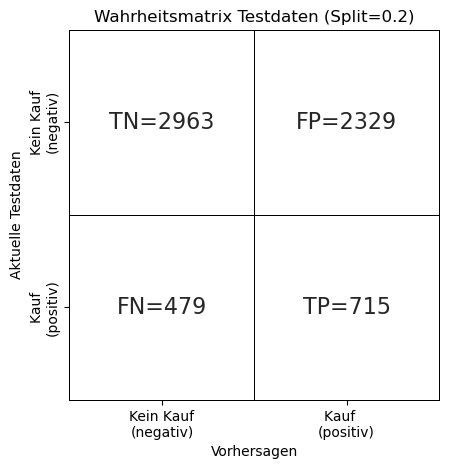

In [8]:
# Wahrheitsmatrix und Maßzahlen der Vorhersage untersuchen

# Adding classes names for better interpretation
classes_names = ['Kein Kauf\n(negativ)','Kauf   \n(positiv)']
cm = met.confusion_matrix(y_test, y_pred);
cmdf = pd.DataFrame(cm, columns=classes_names, index = classes_names); # data frame bilden
tn, fp, fn, tp = cm.ravel();

# Seaborn's heatmap to visualize the confusion matrix
sns.heatmap(data=cmdf, cmap='gray_r', vmin=0, vmax=0,
                 annot=[[f"TN={tn:.0f}", f"FP={fp:.0f}"], [f"FN={fn:.0f}", f"TP={tp:.0f}"]],
                 linewidths=0.5, linecolor='k',  # draw black grid lines
                 clip_on=False,                  # inhibits clipping of right and lower square lines
                 fmt='', annot_kws={'fontsize': 16}, cbar=False, square=True);

plt.title("Wahrheitsmatrix Testdaten (Split="+str(TESTANTEIL)+")");
plt.ylabel('Aktuelle Testdaten');
plt.xlabel('Vorhersagen');

print("Testdatenanteil= "+str(TESTANTEIL))
print ("\nTP:TN:FP:FN = " + str (tp) +":" + str (tn) +":" + str (fp) +":" + str (fn) )
print ("Genauigkeit = {:.2f}".format(met.accuracy_score(y_test, y_pred)))
print ("Recall = {:.2f}".format(met.recall_score(y_test, y_pred, average='binary')))
print ("Präzision = {:.2f}".format(met.precision_score(y_test, y_pred, average='binary')))
print ("F1 Wert = {:.2f}".format(met.f1_score(y_test, y_pred, average='binary')))
print ("Speziftät = {:.2f}".format(tn /(tn+fp)))
print ("TPR = {:.2f}".format(tp /(tp+fp)))
print ("FPR = {:.2f}".format(fp /(tn+fn)))
print ("TNR = {:.2f}".format(tn /(tn+fn)))
print ("FNR = {:.2f}".format(fn /(tp+fp)))

print ("\nUmsatzsteigerung für die Testdaten = {:.2f}".format(1.5*tn - 5.0*fn)+"€")
print ("Umsatzsteigerung für hochgerechnet für alle Testdaten = {:.2f}".format((1.5*tn - 5.0*fn) * (1/TESTANTEIL) ) +"€")
print ("Umsatzsteigerung für baseline (Gutschein an Alle) = {:.2f}".format((df.shape[0] * (1-classratio) * 1.5) -\
                                                                           (df.shape[0] * classratio * 5)) +"€")

